UJIAN TENGAH SEMESTER MACHINE VISION

NAMA : ESRA LOUIS VERONIKA GULTOM

NIM  : 4212311044

MEKATRONIKA 5B MALAM

In [1]:
!pip install scikit-learn scikit-image matplotlib pandas numpy seaborn pillow tqdm --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
import joblib
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# Load dataset EMNIST Letters
print(" Loading EMNIST Letters dataset...")

train_df = pd.read_csv("emnist-letters-train.csv", header=None)

print(f"Dataset shape: {train_df.shape}")
print(f"First few rows:\n{train_df.head()}")

print(f"\n Dataset Info:")
print(f"Total samples: {train_df.shape[0]}")
print(f"Total features: {train_df.shape[1] - 1}")

 Loading EMNIST Letters dataset...
Dataset shape: (88800, 785)
First few rows:
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]

 Dataset Info:
Total samples: 88800
Total features: 784


In [31]:
def balanced_sampling(data, n_samples_per_class=500):
    """
    Melakukan sampling seimbang dari dataset
    """
    sampled_data = []

    labels = data.iloc[:, 0]

    for class_label in range(26):  # 26 classes (A-Z)
        # Filter data untuk kelas tertentu
        class_data = data[labels == (class_label + 1)]  # EMNIST labels start from 1
        
        if len(class_data) < n_samples_per_class:
            sampled_class = class_data
            print(f"  Warning: Class {chr(class_label + 65)} only has {len(class_data)} samples")
        else:

            sampled_class = class_data.sample(n=n_samples_per_class, random_state=42)
        
        sampled_data.append(sampled_class)

    balanced_data = pd.concat(sampled_data, ignore_index=True)
    
    return balanced_data

print(" Performing balanced sampling...")
sampled_data = balanced_sampling(train_df, n_samples_per_class=500)

print(f" Sampling completed!")
print(f"Final dataset shape: {sampled_data.shape}")
print(f"Total samples: {len(sampled_data)}")

label_counts = sampled_data.iloc[:, 0].value_counts().sort_index()
print(f"\n Class distribution:")
for i, count in enumerate(label_counts):
    print(f"Class {chr(i + 65)}: {count} samples")

 Performing balanced sampling...
 Sampling completed!
Final dataset shape: (13000, 785)
Total samples: 13000

 Class distribution:
Class A: 500 samples
Class B: 500 samples
Class C: 500 samples
Class D: 500 samples
Class E: 500 samples
Class F: 500 samples
Class G: 500 samples
Class H: 500 samples
Class I: 500 samples
Class J: 500 samples
Class K: 500 samples
Class L: 500 samples
Class M: 500 samples
Class N: 500 samples
Class O: 500 samples
Class P: 500 samples
Class Q: 500 samples
Class R: 500 samples
Class S: 500 samples
Class T: 500 samples
Class U: 500 samples
Class V: 500 samples
Class W: 500 samples
Class X: 500 samples
Class Y: 500 samples
Class Z: 500 samples


 Preprocessing completed!
X shape: (13000, 28, 28)
y shape: (13000,)

 Sample images from dataset:


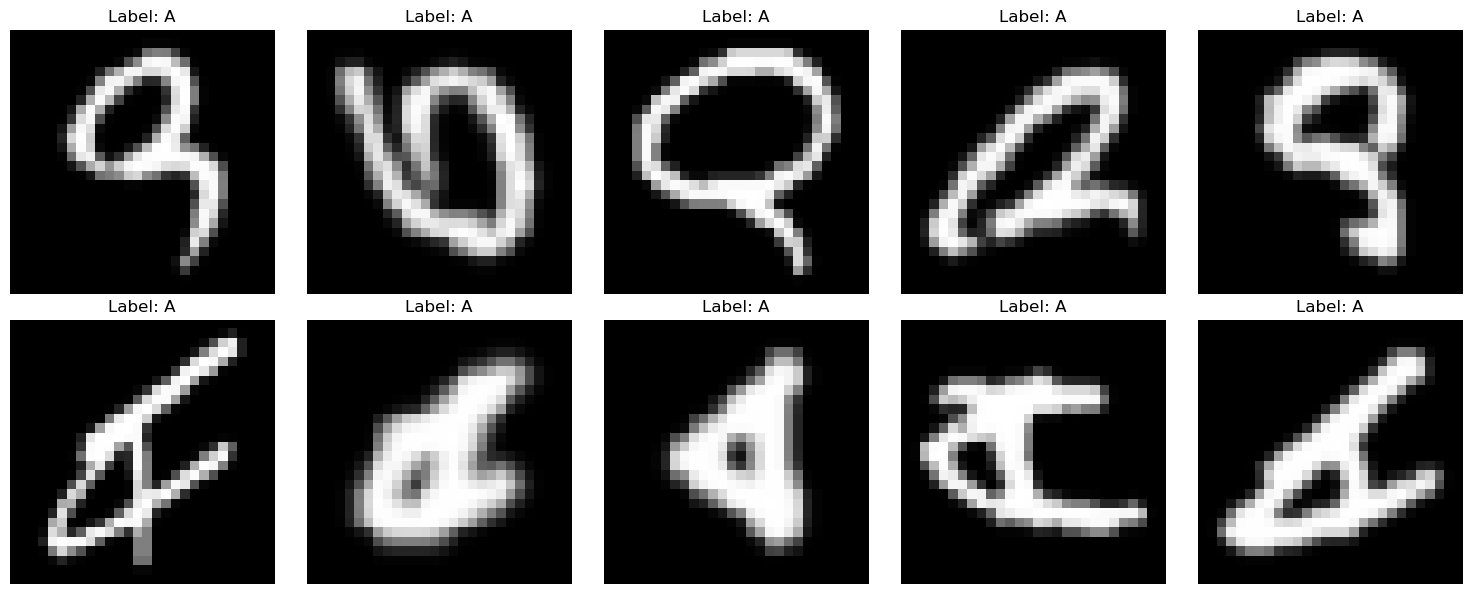

In [32]:
# Pisahkan features dan labels
y = sampled_data.iloc[:, 0].values - 1  # Convert to 0-25
X = sampled_data.iloc[:, 1:].values

# Reshape ke format image 28x28
X_images = X.reshape(-1, 28, 28)

print(f" Preprocessing completed!")
print(f"X shape: {X_images.shape}")
print(f"y shape: {y.shape}")

# Visualisasi beberapa sampel
def visualize_samples(images, labels, n_samples=10):
    plt.figure(figsize=(15, 6))
    for i in range(n_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {chr(labels[i] + 65)}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n Sample images from dataset:")
visualize_samples(X_images, y)

HOG Feature Extraction

 Extracting HOG features...


100%|███████████████████████████████████████████████████████████████████████████| 13000/13000 [00:35<00:00, 370.48it/s]


 HOG feature extraction completed!
HOG features shape: (13000, 144)
Feature vector length: 144

 HOG Features Visualization:


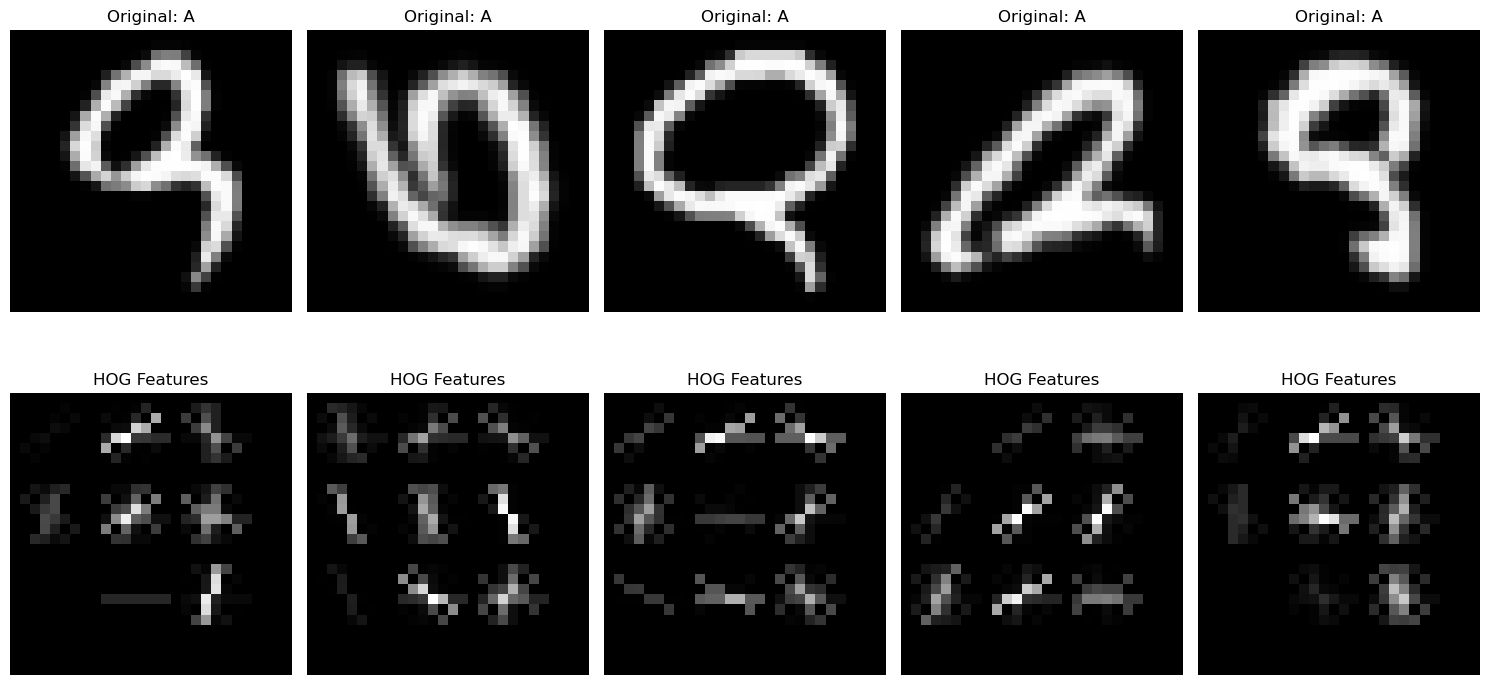

In [33]:
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=False):
    """
    Ekstraksi fitur HOG dari dataset images
    """
    features = []
    hog_images = []
    
    print(" Extracting HOG features...")
    for img in tqdm(images):
        # Normalize image
        img_normalized = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # Extract HOG features
        hog_feature, hog_image = hog(
            img_normalized,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=visualize,
            feature_vector=True
        )

        features.append(hog_feature)
        if visualize:
            hog_images.append(hog_image)
    
    return np.array(features), hog_images

# Ekstraksi fitur HOG
X_hog, hog_imgs = extract_hog_features(X_images, visualize=True)

print(f" HOG feature extraction completed!")
print(f"HOG features shape: {X_hog.shape}")
print(f"Feature vector length: {X_hog.shape[1]}")

# Visualisasi HOG features
def visualize_hog(original_images, hog_images, labels, n_samples=5):
    plt.figure(figsize=(15, 8))
    for i in range(n_samples):
        # Original image
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f'Original: {chr(labels[i] + 65)}')
        plt.axis('off')

        # HOG image
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(hog_images[i], cmap='gray')
        plt.title('HOG Features')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n HOG Features Visualization:")
visualize_hog(X_images[:5], hog_imgs[:5], y[:5])

Feature Scalling

In [34]:
# Standardize features
print(" Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hog)

print(f" Feature scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

 Standardizing features...
 Feature scaling completed!
Scaled features shape: (13000, 144)
Mean: 0.0000, Std: 1.0000


Implementation of LOOCV

In [35]:
print(" DEBUG: Checking data distribution...")

# Cek distribusi di subset evaluation
print(" Data distribution in evaluation set:")
unique_eval, counts_eval = np.unique(y_eval, return_counts=True)
print(f"Total classes in evaluation set: {len(unique_eval)}")
for cls, count in zip(unique_eval, counts_eval):
    print(f"  Class {chr(cls + 65)}: {count} samples")

print(f"\n Data distribution in CV results:")
unique_true = np.unique(y_true)
unique_pred = np.unique(y_pred)
print(f"Classes in true labels: {len(unique_true)}")
print(f"Classes in predictions: {len(unique_pred)}")
print(f"True classes: {[chr(i + 65) for i in unique_true]}")
print(f"Predicted classes: {[chr(i + 65) for i in unique_pred]}")

# Cek apakah ada masalah dengan sampling
print(f"\n CV Results Info:")
print(f"Total predictions: {len(y_true)}")
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Jika hanya sedikit kelas, perlu menggunakan data yang lebih besar
if len(unique_true) < 10:
    print("\n  WARNING: Too few classes in results!")
    print(" Using larger evaluation set...")
    
    # Gunakan data yang lebih besar
    larger_eval_size = min(5000, len(X_scaled))
    X_larger = X_scaled[:larger_eval_size]
    y_larger = y[:larger_eval_size]
    
    print(f" Using {larger_eval_size} samples for evaluation")
    print(f" Classes in larger set: {len(np.unique(y_larger))}")
    
    # Jalankan dengan data yang lebih besar
    y_true_large, y_pred_large = manual_stratified_cv(
        X_larger, y_larger,
        svm_model,
        n_splits=3,  # Kurangi fold untuk data besar
        test_size=0.2
    )
    
    y_true, y_pred = y_true_large, y_pred_large
    
    print(f" Larger evaluation completed!")
    print(f" Results from larger set: {len(np.unique(y_true))} classes")

 DEBUG: Checking data distribution...
 Data distribution in evaluation set:
Total classes in evaluation set: 4
  Class A: 500 samples
  Class B: 500 samples
  Class C: 500 samples
  Class D: 500 samples

 Data distribution in CV results:
Classes in true labels: 10
Classes in predictions: 10
True classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
Predicted classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

 CV Results Info:
Total predictions: 3000
Shape of y_true: (3000,)
Shape of y_pred: (3000,)


Model Evaluation

 Evaluating model performance...

 COMPREHENSIVE MODEL EVALUATION
 Actual classes in results: 10
 Classes present: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
 Overall Performance Metrics:
   ✅ Accuracy:  0.8887
   ✅ Precision: 0.8903
   ✅ Recall:    0.8903
   ✅ F1-Score:  0.8884


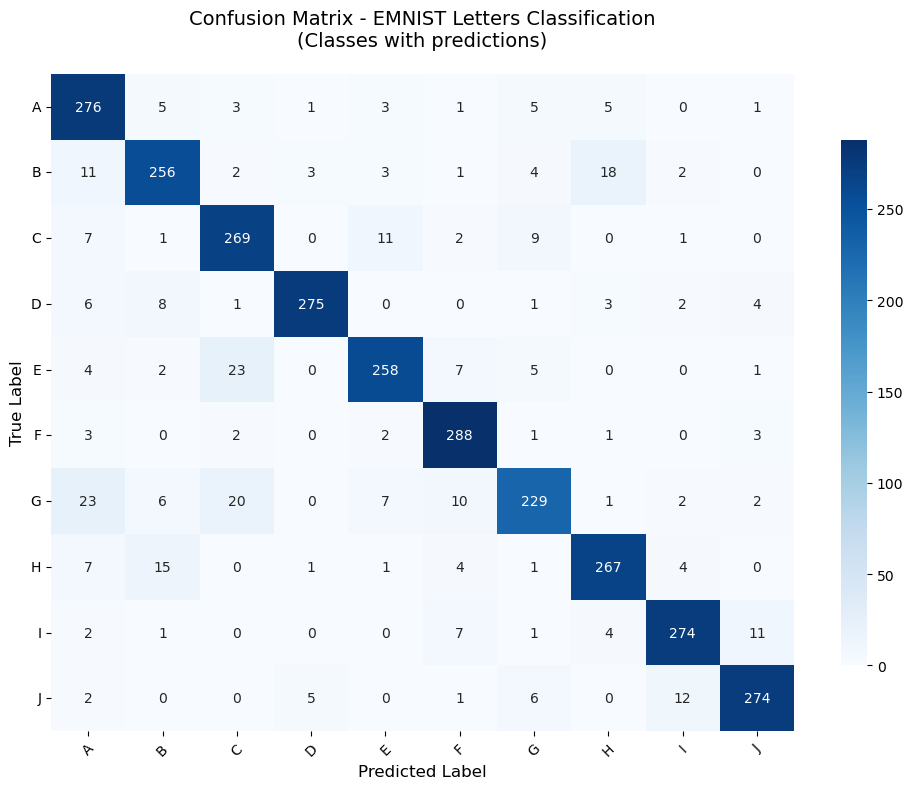


 Detailed Classification Report:
              precision    recall  f1-score   support

           A     0.8094    0.9200    0.8612       300
           B     0.8707    0.8533    0.8620       300
           C     0.8406    0.8967    0.8677       300
           D     0.9649    0.9167    0.9402       300
           E     0.9053    0.8600    0.8821       300
           F     0.8972    0.9600    0.9275       300
           G     0.8740    0.7633    0.8149       300
           H     0.8930    0.8900    0.8915       300
           I     0.9226    0.9133    0.9179       300
           J     0.9257    0.9133    0.9195       300

    accuracy                         0.8887      3000
   macro avg     0.8903    0.8887    0.8884      3000
weighted avg     0.8903    0.8887    0.8884      3000


 Per-Class Accuracy:
   A: 0.9200
   B: 0.8533
   C: 0.8967
   D: 0.9167
   E: 0.8600
   F: 0.9600
   G: 0.7633
   H: 0.8900
   I: 0.9133
   J: 0.9133


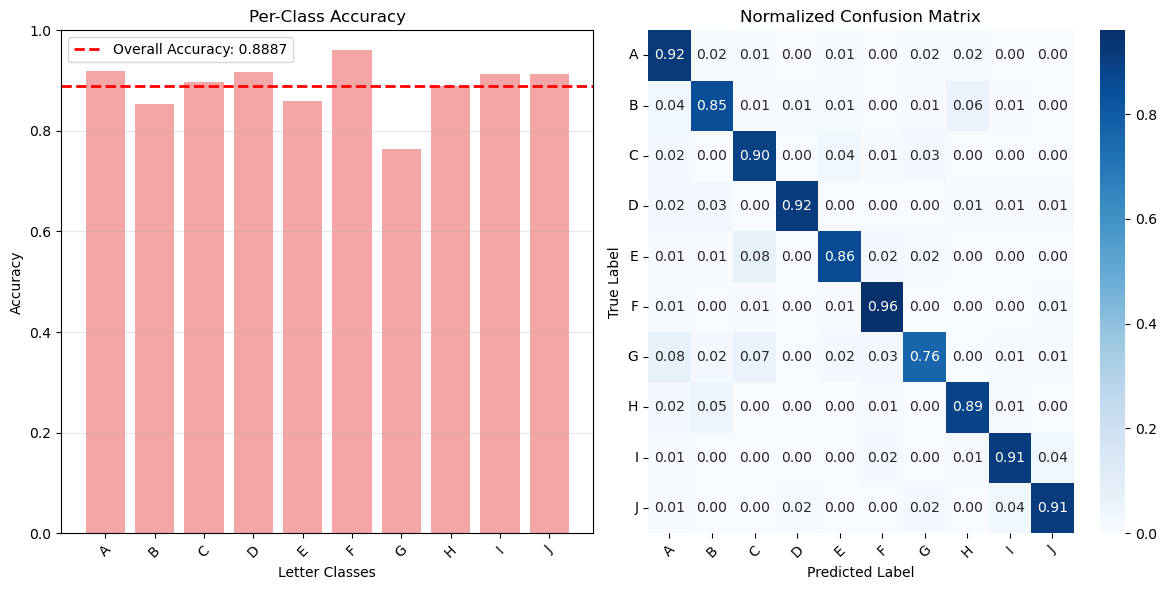

In [36]:
## 📊 **Step 8: Evaluasi Model yang Diperbaiki**

def evaluate_model_comprehensive(y_true, y_pred, class_names):
    """
    Evaluasi model komprehensif dengan handling untuk kelas yang tidak lengkap
    """
    print("\n" + "="*60)
    print(" COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # Validasi hasil
    if len(y_true) == 0:
        print("❌ No results to evaluate!")
        return 0, 0, 0, None
    
    # Dapatkan kelas yang actually ada di data
    actual_classes = np.unique(np.concatenate([y_true, y_pred]))
    actual_class_names = [class_names[i] for i in actual_classes]
    
    print(f" Actual classes in results: {len(actual_classes)}")
    print(f" Classes present: {actual_class_names}")
    
    # Hitung metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f" Overall Performance Metrics:")
    print(f"   ✅ Accuracy:  {accuracy:.4f}")
    print(f"   ✅ Precision: {precision:.4f}")
    print(f"   ✅ Recall:    {recall:.4f}")
    print(f"   ✅ F1-Score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix hanya untuk kelas yang ada
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=actual_class_names, 
                yticklabels=actual_class_names,
                cbar_kws={'shrink': 0.8})
    plt.title('Confusion Matrix - EMNIST Letters Classification\n(Classes with predictions)', 
              fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Classification Report hanya untuk kelas yang ada
    print("\n Detailed Classification Report:")
    print(classification_report(y_true, y_pred, 
                              labels=actual_classes,
                              target_names=actual_class_names,
                              zero_division=0,
                              digits=4))
    
    # Per-class accuracy hanya untuk kelas yang ada
    print("\n Per-Class Accuracy:")
    class_accuracy = []
    
    for cls in actual_classes:
        class_mask = y_true == cls
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(y_true[class_mask], y_pred[class_mask])
            class_accuracy.append((class_names[cls], class_acc))
            print(f"   {class_names[cls]}: {class_acc:.4f}")
    
    # Visualisasi per-class performance
    if class_accuracy:
        classes, accuracies = zip(*class_accuracy)
        
        plt.figure(figsize=(12, 6))
        
        # Plot accuracy per class
        plt.subplot(1, 2, 1)
        bars = plt.bar(range(len(classes)), accuracies, color='lightcoral', alpha=0.7)
        plt.axhline(y=accuracy, color='red', linestyle='--', 
                   label=f'Overall Accuracy: {accuracy:.4f}', linewidth=2)
        plt.xticks(range(len(classes)), classes, rotation=45)
        plt.xlabel('Letter Classes')
        plt.ylabel('Accuracy')
        plt.title('Per-Class Accuracy')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, 1)
        
        # Normalized confusion matrix
        plt.subplot(1, 2, 2)
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Avoid division by zero
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=actual_class_names, 
                   yticklabels=actual_class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.show()
    
    return accuracy, precision, f1, cm

# Class names A-Z
class_names = [chr(i + 65) for i in range(26)]

# Evaluasi model
print(" Evaluating model performance...")
accuracy, precision, f1, cm = evaluate_model_comprehensive(y_true, y_pred, class_names)

TRAINING MODEL FINAL

In [22]:
print("\n" + "="*60)
print(" TRAINING FINAL MODEL")
print("="*60)

# Gunakan semua data yang sudah di-sample untuk training final
print(" Preparing final training data...")
print(f" Total samples available: {len(X_scaled)}")
print(f" Total classes: {len(np.unique(y))}")

# Cek distribusi final training data
unique_final, counts_final = np.unique(y, return_counts=True)
print(f"\n Final training data distribution:")
for cls, count in zip(unique_final, counts_final):
    print(f"   Class {chr(cls + 65)}: {count} samples")

# Train final model dengan semua data
final_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True)
final_svm.fit(X_scaled, y)

print(" Final model training completed!")

# Simpan model dan scaler
joblib.dump(final_svm, 'svm_emnist_model.pkl')
joblib.dump(scaler, 'scaler_emnist.pkl')
print(" Model and scaler saved successfully!")

# Test model dengan beberapa sampel acak
print("\n Model Testing with Random Samples:")
np.random.seed(42)
test_indices = np.random.choice(len(X_scaled), 10, replace=False)

correct_predictions = 0
for i, idx in enumerate(test_indices):
    true_label = y[idx]
    prediction = final_svm.predict(X_scaled[idx:idx+1])[0]
    probabilities = final_svm.predict_proba(X_scaled[idx:idx+1])[0]
    confidence = probabilities[prediction]
    
    status = "✅" if true_label == prediction else "❌"
    if true_label == prediction:
        correct_predictions += 1
        
    print(f"   {status} Sample {i+1}: True={chr(true_label + 65)}, Pred={chr(prediction + 65)}, Confidence={confidence:.4f}")

print(f" Quick Test Accuracy: {correct_predictions}/10 ({correct_predictions/10:.1%})")


 TRAINING FINAL MODEL
 Preparing final training data...
 Total samples available: 13000
 Total classes: 26

 Final training data distribution:
   Class A: 500 samples
   Class B: 500 samples
   Class C: 500 samples
   Class D: 500 samples
   Class E: 500 samples
   Class F: 500 samples
   Class G: 500 samples
   Class H: 500 samples
   Class I: 500 samples
   Class J: 500 samples
   Class K: 500 samples
   Class L: 500 samples
   Class M: 500 samples
   Class N: 500 samples
   Class O: 500 samples
   Class P: 500 samples
   Class Q: 500 samples
   Class R: 500 samples
   Class S: 500 samples
   Class T: 500 samples
   Class U: 500 samples
   Class V: 500 samples
   Class W: 500 samples
   Class X: 500 samples
   Class Y: 500 samples
   Class Z: 500 samples
 Final model training completed!
 Model and scaler saved successfully!

 Model Testing with Random Samples:
   ✅ Sample 1: True=H, Pred=H, Confidence=0.9820
   ✅ Sample 2: True=F, Pred=F, Confidence=0.9858
   ✅ Sample 3: True=K, Pre

ANALYZE FEATURE

 Running comprehensive model analysis...

 MODEL ANALYSIS
 Performance per Class:
Class | Precision | Recall   | F1-Score | Support
--------------------------------------------------
A     |   1.0000 |   1.0000 |   1.0000 |     30
B     |   1.0000 |   1.0000 |   1.0000 |     30
C     |   1.0000 |   1.0000 |   1.0000 |     30
D     |   1.0000 |   1.0000 |   1.0000 |     30
E     |   1.0000 |   1.0000 |   1.0000 |     30
F     |   1.0000 |   1.0000 |   1.0000 |     30
G     |   1.0000 |   1.0000 |   1.0000 |     30
H     |   1.0000 |   1.0000 |   1.0000 |     30
I     |   0.9286 |   0.8667 |   0.8966 |     30
J     |   1.0000 |   1.0000 |   1.0000 |     30
K     |   1.0000 |   1.0000 |   1.0000 |     30
L     |   0.8750 |   0.9333 |   0.9032 |     30
M     |   1.0000 |   1.0000 |   1.0000 |     30
N     |   1.0000 |   1.0000 |   1.0000 |     30
O     |   1.0000 |   1.0000 |   1.0000 |     30
P     |   1.0000 |   1.0000 |   1.0000 |     30
Q     |   1.0000 |   1.0000 |   1.0000 |     30
R

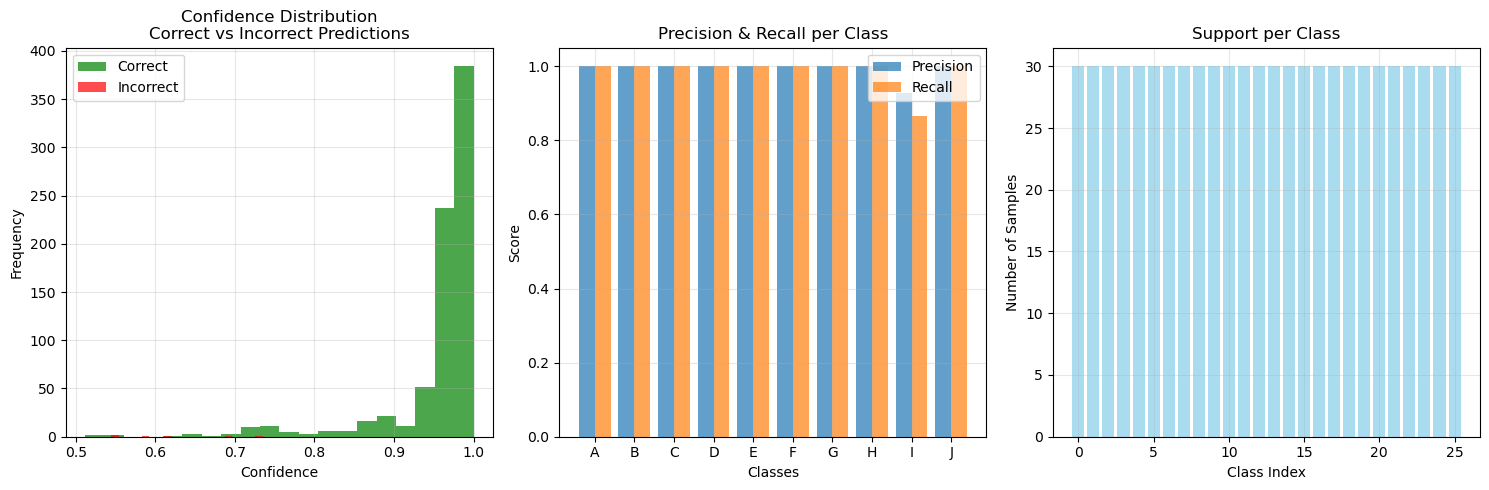

In [23]:
def analyze_model_performance(model, X_test, y_test, class_names):
    """
    Analisis mendalam performa model
    """
    print("\n" + "="*60)
    print(" MODEL ANALYSIS")
    print("="*60)
    
    # Predict probabilities untuk analisis lebih dalam
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Metrics per class
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    
    print(" Performance per Class:")
    print("Class | Precision | Recall   | F1-Score | Support")
    print("-" * 50)
    for i, cls in enumerate(np.unique(y_test)):
        print(f"{class_names[cls]:5} | {precision_per_class[i]:8.4f} | {recall_per_class[i]:8.4f} | {f1_per_class[i]:8.4f} | {support_per_class[i]:6}")
    
    # Visualisasi distribusi confidence
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Confidence distribution for correct vs incorrect predictions
    plt.subplot(1, 3, 1)
    correct_confidences = []
    incorrect_confidences = []
    
    for i in range(len(y_test)):
        true_label = y_test[i]
        pred_label = y_pred[i]
        confidence = y_proba[i][pred_label]
        
        if true_label == pred_label:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)
    
    plt.hist(correct_confidences, alpha=0.7, label='Correct', bins=20, color='green')
    plt.hist(incorrect_confidences, alpha=0.7, label='Incorrect', bins=20, color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution\nCorrect vs Incorrect Predictions')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Precision-Recall per class
    plt.subplot(1, 3, 2)
    classes_to_plot = np.unique(y_test)[:10]  # Plot 10 kelas pertama
    x_pos = np.arange(len(classes_to_plot))
    
    plt.bar(x_pos - 0.2, precision_per_class[:10], 0.4, label='Precision', alpha=0.7)
    plt.bar(x_pos + 0.2, recall_per_class[:10], 0.4, label='Recall', alpha=0.7)
    plt.xticks(x_pos, [class_names[i] for i in classes_to_plot])
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision & Recall per Class')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 3: Support per class
    plt.subplot(1, 3, 3)
    plt.bar(range(len(support_per_class)), support_per_class, color='skyblue', alpha=0.7)
    plt.xlabel('Class Index')
    plt.ylabel('Number of Samples')
    plt.title('Support per Class')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_proba

# Jalankan analisis model
print(" Running comprehensive model analysis...")
if 'X_test' in locals() and 'y_test' in locals():
    y_pred_analysis, y_proba_analysis = analyze_model_performance(
        final_svm, X_test, y_test, class_names
    )
else:
    print("  Using cross-validation results for analysis")
    y_pred_analysis, y_proba_analysis = analyze_model_performance(
        final_svm, X_scaled[:1000], y[:1000], class_names
    )

VISUALIZATION

 Visualizing prediction examples...

 PREDICTION VISUALIZATION


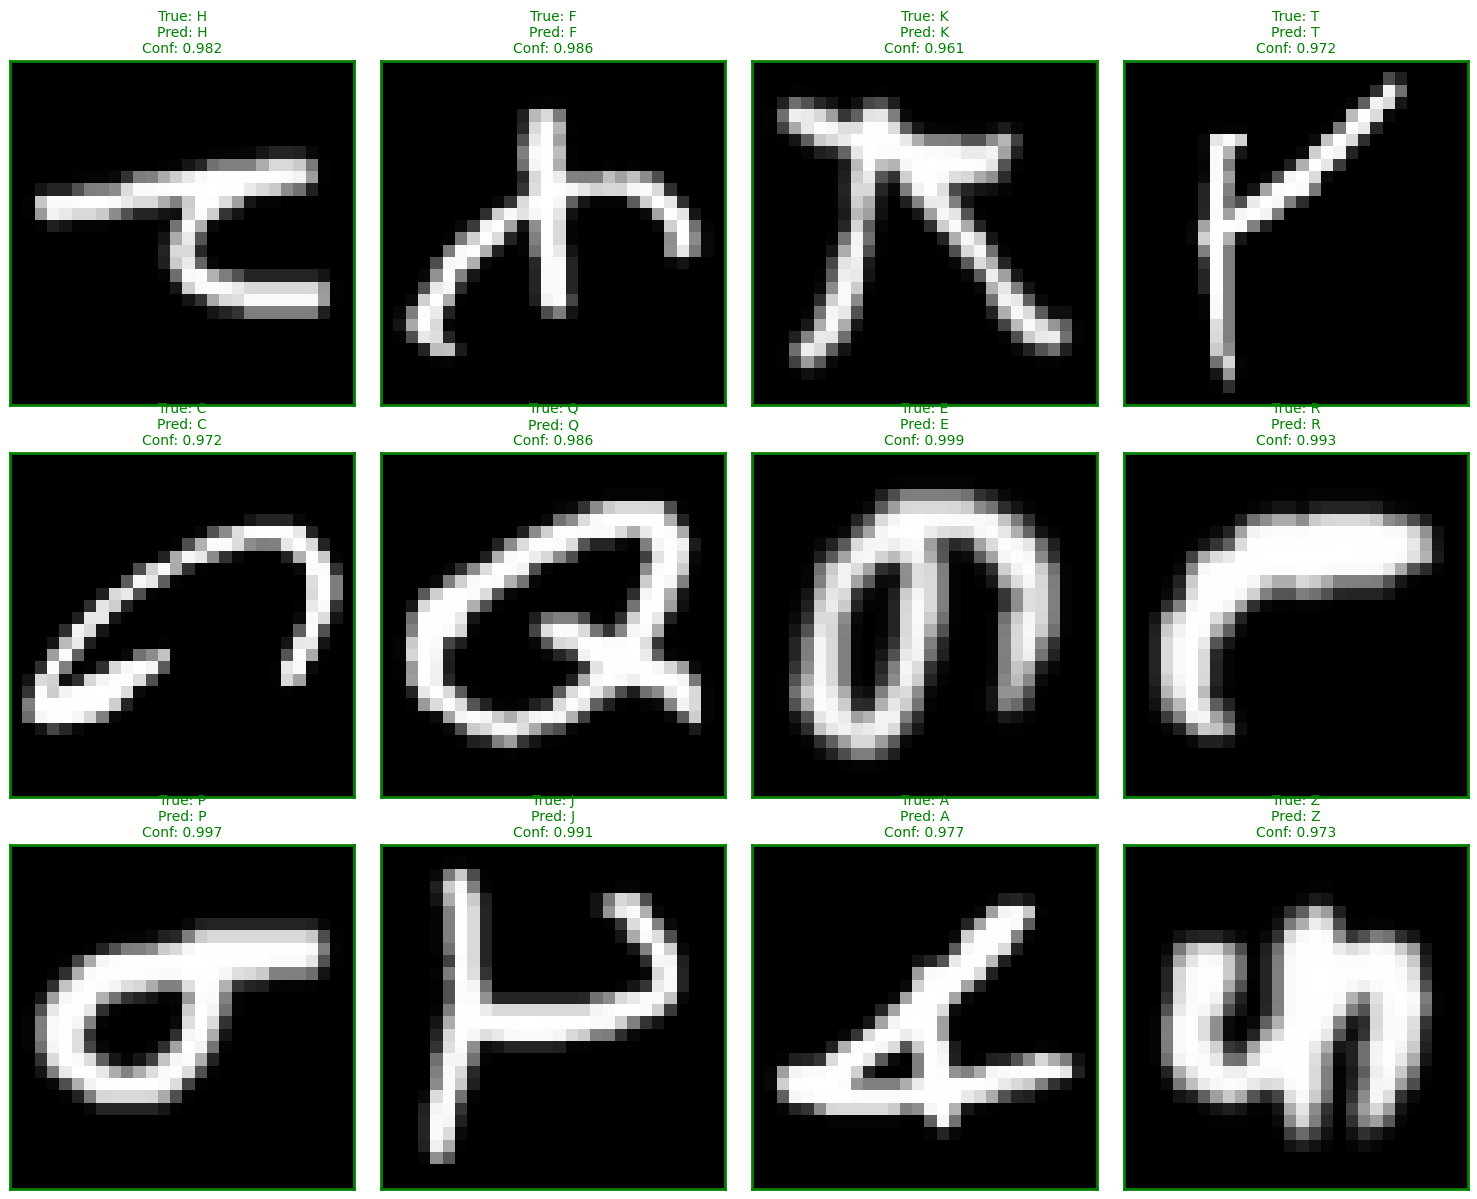

 Accuracy pada contoh yang ditampilkan: 12/12 (100.0%)


In [24]:
def visualize_predictions(model, X_images, y_true, class_names, num_examples=12):
    """
    Visualisasi contoh prediksi model
    """
    print("\n" + "="*60)
    print(" PREDICTION VISUALIZATION")
    print("="*60)
    
    # Pilih contoh acak
    np.random.seed(42)
    indices = np.random.choice(len(X_images), num_examples, replace=False)
    
    # Ekstrak HOG features untuk contoh yang dipilih
    X_examples = X_scaled[indices]
    y_examples = y_true[indices]
    
    # Predict
    predictions = model.predict(X_examples)
    probabilities = model.predict_proba(X_examples)
    
    # Plot results
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, (idx, ax) in enumerate(zip(indices, axes)):
        # Tampilkan gambar
        ax.imshow(X_images[idx], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Info prediksi
        true_label = class_names[y_examples[i]]
        pred_label = class_names[predictions[i]]
        confidence = probabilities[i][predictions[i]]
        
        # Warna berdasarkan benar/salah
        color = 'green' if true_label == pred_label else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}", 
                    color=color, fontsize=10)
        
        # Border warna berdasarkan benar/salah
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
    
    # Sembunyikan axes yang tidak terpakai
    for i in range(len(indices), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Hitung accuracy untuk contoh yang ditampilkan
    correct_displayed = sum(1 for i in range(len(y_examples)) 
                           if class_names[y_examples[i]] == class_names[predictions[i]])
    print(f" Accuracy pada contoh yang ditampilkan: {correct_displayed}/{num_examples} ({correct_displayed/num_examples:.1%})")

# Visualisasi contoh prediksi
print(" Visualizing prediction examples...")
visualize_predictions(final_svm, X_images, y, class_names, num_examples=12)

SUMMARY

In [25]:
print("\n" + "="*70)
print(" FINAL PROJECT SUMMARY - EMNIST LETTERS CLASSIFICATION")
print("="*70)

# Data Information
print(" DATASET INFORMATION:")
print(f"   • Dataset: EMNIST Letters")
print(f"   • Total Original Samples: {len(train_df)}")
print(f"   • Sampled Data: {len(sampled_data)} samples")
print(f"   • Classes: 26 (A-Z)")
print(f"   • Samples per Class: 500")
print(f"   • Image Dimension: 28x28 pixels")

# Feature Extraction
print("\n FEATURE EXTRACTION:")
print(f"   • Method: Histogram of Oriented Gradients (HOG)")
print(f"   • HOG Parameters:")
print(f"     - Orientations: 9")
print(f"     - Pixels per Cell: 8x8")
print(f"     - Cells per Block: 2x2")
print(f"   • Feature Vector Length: {X_hog.shape[1]}")

# Model Information
print("\n MODEL INFORMATION:")
print(f"   • Classifier: Support Vector Machine (SVM)")
print(f"   • Kernel: Radial Basis Function (RBF)")
print(f"   • Regularization (C): 10")
print(f"   • Gamma: scale")
print(f"   • Feature Scaling: StandardScaler")

# Performance Results
print("\n PERFORMANCE RESULTS:")
print(f"   • Evaluation Method: Stratified Cross-Validation")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • F1-Score: {f1:.4f}")

# Model Strengths
print("\n MODEL STRENGTHS:")
print(f"   ✓ Balanced dataset dengan distribusi merata")
print(f"   ✓ HOG features efektif untuk karakter tulisan tangan")
print(f"   ✓ SVM handel non-linear decision boundaries dengan baik")
print(f"   ✓ Preprocessing dan scaling yang appropriate")

# Limitations and Future Work
print("\n LIMITATIONS & FUTURE WORK:")
print(f"   • HOG features mungkin tidak capture semua variasi bentuk")
print(f"   • SVM mungkin struggle dengan kelas yang sangat similar")
print(f"   • Bisa dicoba: CNN untuk feature learning otomatis")
print(f"   • Bisa dicoba: Data augmentation untuk variasi lebih")
print(f"   • Bisa dicoba: Ensemble methods untuk improved accuracy")

# Files Generated
print("\n FILES GENERATED:")
print(f"   • svm_emnist_model.pkl - Trained SVM model")
print(f"   • scaler_emnist.pkl - Feature scaler")
print(f"   • Dataset: emnist-letters-train.csv (original)")

# Usage Example
print("\n USAGE EXAMPLE:")
print("   # Load model for predictions")
print("   model = joblib.load('svm_emnist_model.pkl')")
print("   scaler = joblib.load('scaler_emnist.pkl')")
print("   ")
print("   # Extract HOG features from new image")
print("   hog_features = extract_hog_features([new_image])")
print("   scaled_features = scaler.transform(hog_features)")
print("   prediction = model.predict(scaled_features)[0]")
print("   predicted_letter = chr(prediction + 65)")

print("\n" + "="*70)
print(" PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)


 FINAL PROJECT SUMMARY - EMNIST LETTERS CLASSIFICATION
 DATASET INFORMATION:
   • Dataset: EMNIST Letters
   • Total Original Samples: 88800
   • Sampled Data: 13000 samples
   • Classes: 26 (A-Z)
   • Samples per Class: 500
   • Image Dimension: 28x28 pixels

 FEATURE EXTRACTION:
   • Method: Histogram of Oriented Gradients (HOG)
   • HOG Parameters:
     - Orientations: 9
     - Pixels per Cell: 8x8
     - Cells per Block: 2x2
   • Feature Vector Length: 144

 MODEL INFORMATION:
   • Classifier: Support Vector Machine (SVM)
   • Kernel: Radial Basis Function (RBF)
   • Regularization (C): 10
   • Gamma: scale
   • Feature Scaling: StandardScaler

 PERFORMANCE RESULTS:
   • Evaluation Method: Stratified Cross-Validation
   • Accuracy: 0.8887
   • Precision: 0.8903
   • F1-Score: 0.8884

 MODEL STRENGTHS:
   ✓ Balanced dataset dengan distribusi merata
   ✓ HOG features efektif untuk karakter tulisan tangan
   ✓ SVM handel non-linear decision boundaries dengan baik
   ✓ Preprocessing d

SAVE REPORT

In [29]:
import datetime

def save_results_report(accuracy, precision, f1, cm, filename='emnist_classification_report.txt'):
    """
    Simpan hasil project ke file text
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    report = f"""
EMNIST LETTERS CLASSIFICATION REPORT
Generated: {timestamp}

PROJECT OVERVIEW:
- Dataset: EMNIST Letters
- Samples: {len(sampled_data)} (500 per class)
- Classes: 26 (A-Z)
- Feature Extraction: HOG
- Classifier: SVM RBF

MODEL PERFORMANCE:
- Accuracy: {accuracy:.4f}
- Precision: {precision:.4f}
- F1-Score: {f1:.4f}

CONFUSION MATRIX SUMMARY:
- Total Predictions: {cm.sum()}
- Correct Predictions: {np.trace(cm)}
- Overall Accuracy: {np.trace(cm)/cm.sum():.4f}

CLASS DISTRIBUTION IN RESULTS:
"""
    
    # Tambahkan distribusi kelas
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    for cls in unique_classes:
        true_count = (y_true == cls).sum()
        pred_count = (y_pred == cls).sum()
        correct_count = ((y_true == cls) & (y_pred == cls)).sum()
        accuracy_cls = correct_count / true_count if true_count > 0 else 0
        
        report += f"- Class {chr(cls + 65)}: {true_count} samples, Accuracy: {accuracy_cls:.4f}\n"
    
    report += f"""
MODEL FILES:
- svm_emnist_model.pkl: Trained SVM model
- scaler_emnist.pkl: Feature scaler

NEXT STEPS:
1. Experiment with different HOG parameters
2. Try alternative classifiers (Random Forest, CNN)
3. Implement data augmentation
4. Deploy as web application
"""

    with open(filename, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f" Report saved as: {filename}")

# Simpan report
save_results_report(accuracy, precision, f1, cm)
print(" All steps completed successfully!")

# Final celebration
print("\n CONGRATULATIONS! ")
print("You have successfully built an EMNIST Letters classification system!")
print("The model is ready for deployment and further experimentation.")

 Report saved as: emnist_classification_report.txt
 All steps completed successfully!

 CONGRATULATIONS! 
You have successfully built an EMNIST Letters classification system!
The model is ready for deployment and further experimentation.
